In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
g1, g2, e1, e2, R2, SNR, w16a, imag, lweight = np.load("selbias.npy")

In [3]:
g = np.hypot(g1, g2)
e = np.hypot(e1, e2)
g_angle = 0.5*np.arctan2(g2, g1)  # [-pi/2, pi/2)
e_angle = 0.5*np.arctan2(e2, e1)
g_angle[g_angle<0] += np.pi  # [0, pi)
e_angle[e_angle<0] += np.pi
phi_plus = np.abs(g_angle - e_angle)
# Can't be more than pi/2 misaligned.  Need to reflect
phi_plus[phi_plus>np.pi/2] = np.pi - phi_plus[phi_plus>np.pi/2]

In [4]:
# How many gals does each selection leave behind?
print("total", len(R2))
print()
print("R2", np.sum(R2 > 0.3))
print("imag", np.sum(imag < 24.5))
print("SNR", np.sum(SNR > 10.0))
print()
print("R2 & imag", np.sum((R2 > 0.3) & (imag < 24.5)))
print("R2 & SNR", np.sum((R2 > 0.3) & (SNR > 10.0)))
print("imag & SNR", np.sum((imag < 24.5) & (SNR > 10.0)))
print()
print("all", np.sum((R2 > 0.3) & (imag < 24.5) & (SNR > 10.0)))

total 2529116

R2 2350551
imag 2040381
SNR 2483206

R2 & imag 1889337
R2 & SNR 2304772
imag & SNR 2018549

all 1867511


In [5]:
# What's the median ellipticity?
print(np.median(e))
# ... of things that get selected?
wselect = (R2 > 0.3) & (imag < 24.5) & (SNR > 10.0)
print(np.median(e[wselect]))

0.598844267053
0.581171096458


/Users/josh/src/lsstsw3/miniconda/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


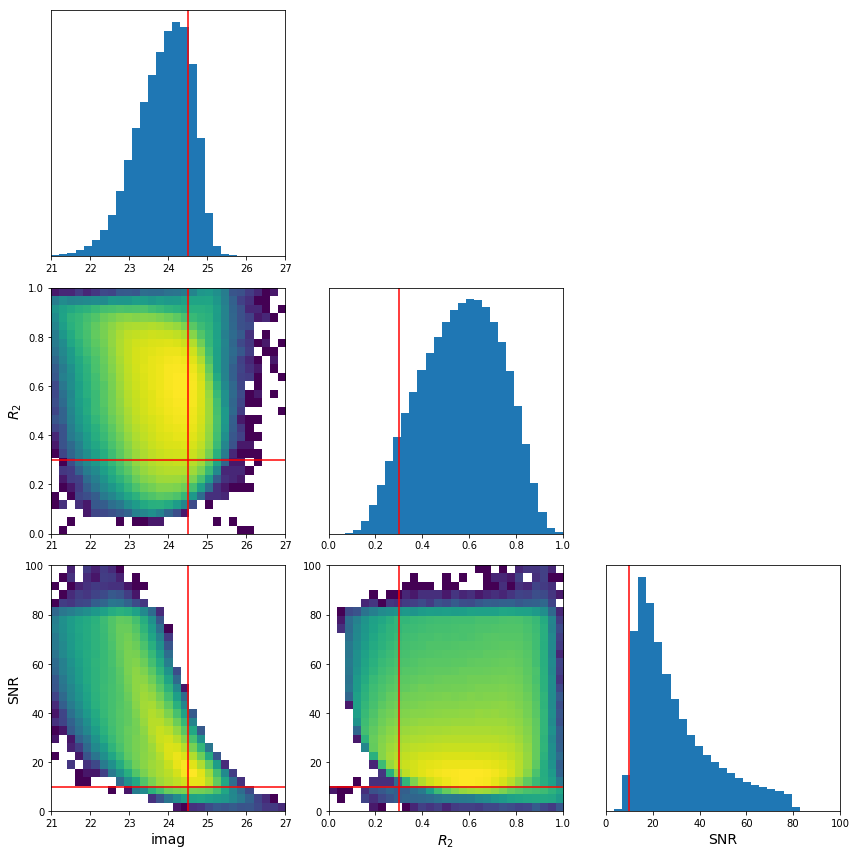

In [6]:
# Manual corner plot
imagbins = np.linspace(21, 27, 30)
R2bins = np.linspace(0, 1, 30)
SNRbins = np.linspace(0, 100, 30)

fig = plt.figure(figsize=(12, 12))

imaghistax = fig.add_subplot(331)
imaghistax.hist(imag, bins=imagbins)
imaghistax.set_xlim(imagbins[0], imagbins[-1])
imaghistax.set_yticks([])
imaghistax.axvline(24.5, c='r')


imagR2ax = fig.add_subplot(334)
imagR2ax.hist2d(imag, R2, bins=[imagbins, R2bins], norm=LogNorm())
imagR2ax.axvline(24.5, c='r')
imagR2ax.axhline(0.3, c='r')
imagR2ax.set_ylabel("$R_2$", fontsize=14)

R2histax = fig.add_subplot(335)
R2histax.hist(R2, bins=R2bins)
R2histax.set_xlim(R2bins[0], R2bins[-1])
R2histax.set_yticks([])
R2histax.axvline(0.3, c='r')


imagSNRax = fig.add_subplot(337)
imagSNRax.hist2d(imag, SNR, bins=[imagbins, SNRbins], norm=LogNorm())
imagSNRax.axvline(24.5, c='r')
imagSNRax.axhline(10.0, c='r')
imagSNRax.set_xlabel("imag", fontsize=14)
imagSNRax.set_ylabel("SNR", fontsize=14)

R2SNRax = fig.add_subplot(338)
R2SNRax.hist2d(R2, SNR, bins=[R2bins, SNRbins], norm=LogNorm())
R2SNRax.axvline(0.3, c='r')
R2SNRax.axhline(10.0, c='r')
R2SNRax.set_xlabel("$R_2$", fontsize=14)

SNRhistax = fig.add_subplot(339)
SNRhistax.hist(SNR, bins=SNRbins)
SNRhistax.set_xlim(SNRbins[0], SNRbins[-1])
SNRhistax.set_yticks([])
SNRhistax.axvline(10.0, c='r')
SNRhistax.set_xlabel("SNR", fontsize=14)


fig.tight_layout()
fig.show()

In [7]:
def plotrange(X):
    Xrange = np.percentile(X, [2.0, 98.0])
    span = Xrange[1] - Xrange[0]
    return Xrange[0]-span*0.2, Xrange[1]+span*0.2

In [17]:
def Acoef(e, g, phi_plus, Z, Zcut, Zspan, Zname, weights=None, ebins=(0, 2), ylim=None, otherselect=None, nbins=50):
    """
    e = ellipticity magnitudes.  Should come in pairs.
    g = shear magnitudes
    phi_plus = abs(angle) between ellipticity and shear
    Z = variable being used to define selection
    Zcut = cutoff value for Z
    Zspan = span defining "near Zcut", can be a list to make multiple reports/trendlines
    Zname = name of Z variable.  Used in plots/text reports
    weights = weight to apply to each Z
    ebins = [0, 2]  list defining ellipticity bins in which to perform analysis
    otherselect = boolean array for doing additional selection
    """
    if not hasattr(Zspan, '__getitem__'):
        Zspan = [Zspan]

    if weights is None:
        weights = w16a

    # Pick one gal from pair randomly to use in selection
    galselector = np.random.choice(2, size=len(Z)//2) + np.arange(0, len(Z), 2)

    # We'll make the background plot using the first item in Zspan and the full ellipticity range
    wpair = Z[galselector] > Zcut - Zspan[0]
    wpair &= Z[galselector] < Zcut + Zspan[1]
    wpair &= e[galselector] > ebins[0]
    wpair &= e[galselector] < ebins[-1]
    if otherselect is not None:
        wpair &= otherselect[galselector]
    
    x = g[::2][wpair] * (np.cos(2*phi_plus[::2][wpair]) - np.cos(2*phi_plus[1::2][wpair]))
    y = Z[::2][wpair] - Z[1::2][wpair]
    pair_weight = weights[::2][wpair]

    xrange = plotrange(x)
    yrange = plotrange(y)
    
    fig, ax = plt.subplots(1, 1)
    im = ax.hist2d(x, y, 
                   bins=[np.linspace(xrange[0], xrange[1], nbins),
                         np.linspace(yrange[0], yrange[1], nbins)],
                   norm=LogNorm(),
                   weights=pair_weight)

    # For the trend lines and text report, loop over possible Zspans and ebins
    xedges = np.linspace(xrange[0], xrange[1], nbins)

    for emin, emax, ls in zip(ebins[:-1], ebins[1:], itertools.cycle(['-', '--', ':', '-.'])):        
        print()
        print()
        print("emin = {}, emax = {}".format(emin, emax))

        for Zsp, c in zip(Zspan, itertools.cycle(['r', 'g', 'b', 'k'])):
            wpair = Z[galselector] > Zcut - Zsp
            wpair &= Z[galselector] < Zcut + Zsp
            wpair &= e[galselector] > emin
            wpair &= e[galselector] < emax
            if otherselect is not None:
                wpair &= otherselect[galselector]

            x = g[::2][wpair] * (np.cos(2*phi_plus[::2][wpair]) - np.cos(2*phi_plus[1::2][wpair]))
            y = Z[::2][wpair] - Z[1::2][wpair]
            pair_weight = weights[::2][wpair]

            xs = []
            ys = []
            for xlo, xhi in zip(xedges[:-1], xedges[1:]):
                ww = (xlo < x) & (x < xhi)
                if np.sum(ww) < 100: # Don't include poorly populated bins
                    continue
                xs.append(0.5*(xlo+xhi))  # Middle of bin, could use bin average?
                ys.append(np.sum(y[ww]*pair_weight[ww])/np.sum(pair_weight[ww]))
            ax.plot(xs, ys, c=c, ls=ls, label="e in [{}, {}], Zsp = {}".format(emin, emax, Zsp))
            wfit = np.isfinite(ys)
            coefs = np.polyfit(np.array(xs)[wfit], np.array(ys)[wfit], deg=1)
            print()
            print("Zspan = {}".format(Zsp))
            print("  m={:8.3g}  b={:8.2g}".format(coefs[0], coefs[1]))

    ax.legend()
    ax.axhline(0.0, c='k')
    ax.axvline(0.0, c='k')

    ax.set_xlabel("$\gamma (\cos(2 \phi_+^{(1)}) - \cos(2 \phi_+^{(2)}))$", fontsize=15)
    ylabel="${{{0}}}^{{(1)}} - {{{0}}}^{{(2)}}$".format(Zname)
    ax.set_ylabel(ylabel, fontsize=15)
    if ylim is not None:
        ax.set_ylim(ylim)
    plt.tight_layout()



emin = 0, emax = 0.58

Zspan = 0.05
  m=   0.112  b=  -0.001

Zspan = 0.03
  m=   0.115  b=  -7e-06

Zspan = 0.01
  m=   0.151  b= -0.0015


emin = 0.58, emax = 2

Zspan = 0.05
  m=    0.14  b=-0.00033

Zspan = 0.03
  m=   0.149  b= 0.00029

Zspan = 0.01
  m=   0.116  b= 0.00051


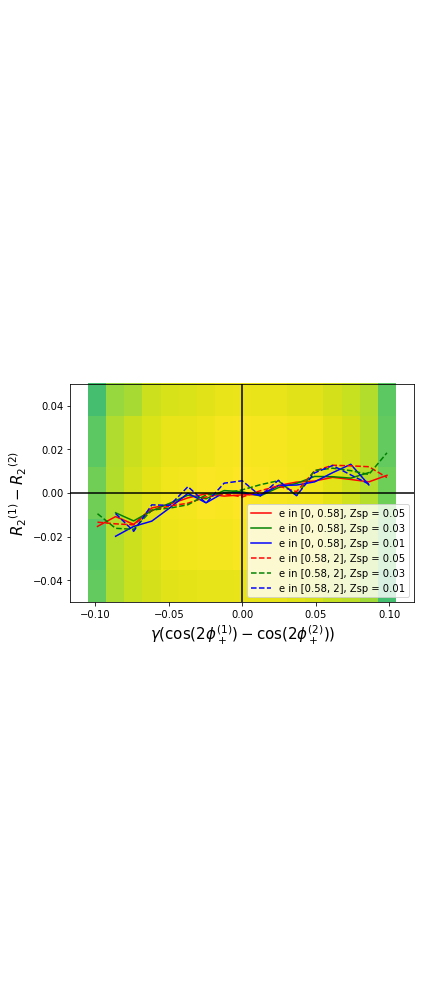

In [19]:
# When evaluating R2 selection bias, we should implement the cuts in SNR and imag
otherselect = (SNR > 10.0) & (imag < 24.5)
Acoef(e, g, phi_plus, R2, 0.3, [0.05, 0.03, 0.01], 'R_2', ebins=(0, 0.58, 2), ylim=(-0.05, 0.05),
      otherselect=otherselect, nbins=20)



emin = 0, emax = 0.58

Zspan = 7
  m=   -1.16  b=   0.013

Zspan = 5
  m=  -0.959  b=  -0.023


emin = 0.58, emax = 2

Zspan = 7
  m=   -4.37  b=   0.039

Zspan = 5
  m=   -3.23  b=   0.039


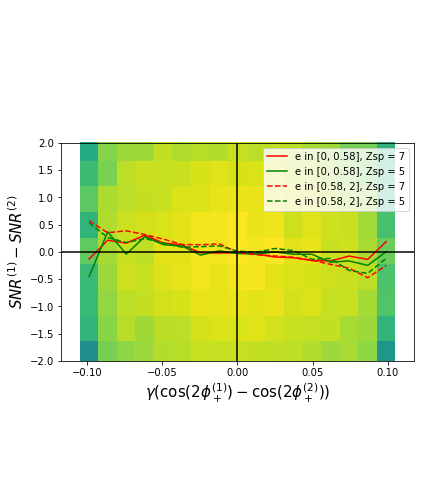

In [22]:
# For SNR bias, implement cuts in R2 and imag
otherselect = (R2 > 0.3) & (imag < 24.5)
Acoef(e, g, phi_plus, SNR, 10.0, [7, 5], 'SNR', ebins=(0, 0.58, 2), ylim=(-2, 2), 
      otherselect=otherselect, nbins=20)



emin = 0, emax = 0.58

Zspan = 0.1
  m=  0.0668  b=  0.0023

Zspan = 0.05
  m=  0.0748  b=  0.0015


emin = 0.58, emax = 2

Zspan = 0.1
  m=   0.168  b= -0.0002

Zspan = 0.05
  m=   0.167  b=-0.00057


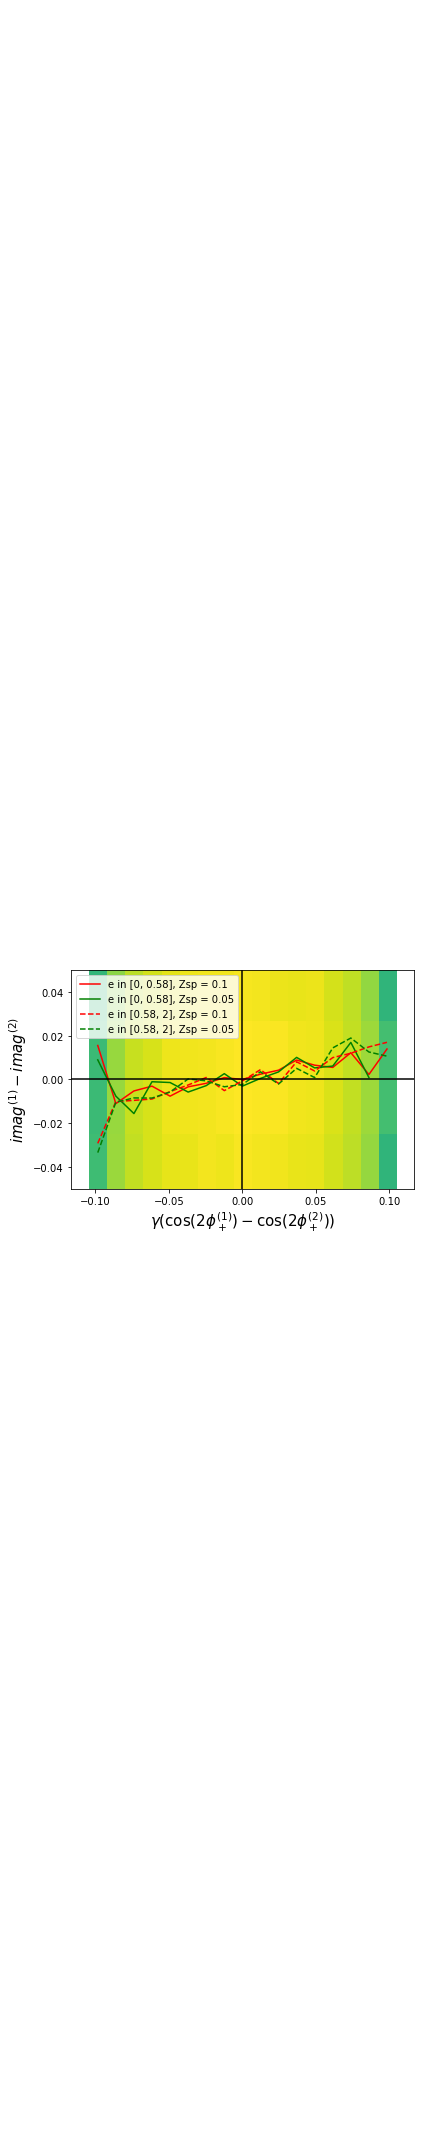

In [23]:
# For imag bias, implement cuts in SNR and R2
otherselect = (R2 > 0.3) & (SNR > 10.0)
Acoef(e, g, phi_plus, imag, 24.5, [0.1, 0.05], 'imag', ebins=(0, 0.58, 2), ylim=(-0.05, 0.05), 
      otherselect=otherselect, nbins=20)